# Main Focus of the Notebook: Running Laptrack on detections

### This notebook takes as input the dataframe which contains filtered detected spots and runs laptrack module on it. 
### A new dataframe containing tree id and track id is returned. For us main variable for tracks is track id. 

In [1]:
from os import path
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from laptrack import LapTrack
import napari
from skimage import io
import time 

Import the dataframe of filtered spots 

In [2]:
path = '/Users/apple/Desktop/Akamatsu_Lab/Lap_track/self/files/cleaned_spots_intensities_c3_all.pkl'
cleaned_spots_df = pd.read_pickle(path)

In [3]:
max_distance = 3
lt = LapTrack(
    track_dist_metric="sqeuclidean",  # The similarity metric for particles. See `scipy.spatial.distance.cdist` for allowed values.
    splitting_dist_metric="sqeuclidean",
    merging_dist_metric="sqeuclidean",
    # the square of the cutoff distance for the "sqeuclidean" metric
    track_cost_cutoff=max_distance**2,
    gap_closing_cost_cutoff = (2*max_distance)**2,
    gap_closing_max_frame_count = 1,
    splitting_cost_cutoff=False,  # or False for non-splitting case
    merging_cost_cutoff=False,  # or False for non-merging case
)

In [5]:

start_time = time.time()

track_df, split_df, merge_df = lt.predict_dataframe(
    cleaned_spots_df,
    coordinate_cols=[
        "mu_x",
        "mu_y",
        "mu_z"
    ],  # the column names for the coordinates
    frame_col="frame",  # the column name for the frame (default "frame")
    only_coordinate_cols=False,  # if False, returned track_df includes columns not in coordinate_cols.
    # False will be the default in the major release.
)

end_time = time.time()

execution_time = end_time - start_time
print(f"Total execution time: {execution_time} seconds")
track_df = track_df.reset_index()

Total execution time: 103.00411200523376 seconds


In [6]:
c3_tracking_pickle_file = "/Users/apple/Desktop/Akamatsu_Lab/Lap_track/self/files/track_df_c3_cleaned.pkl"

# Save the DataFrame to a pickle file
track_df.to_pickle(c3_tracking_pickle_file)

In [8]:
track_df['track_id'].nunique()

18923

In [22]:
track_appearances = track_df['track_id'].value_counts().reset_index()
track_appearances.columns = ['track_id', 'length']
track_appearances.head()

,track_id,length
0,3344,63
1,212,60
2,286,51
3,7239,51
4,12615,49


In [24]:
track_appearances['length'].describe()

count    18923.000000
mean         2.635259
std          3.648437
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         63.000000
Name: length, dtype: float64

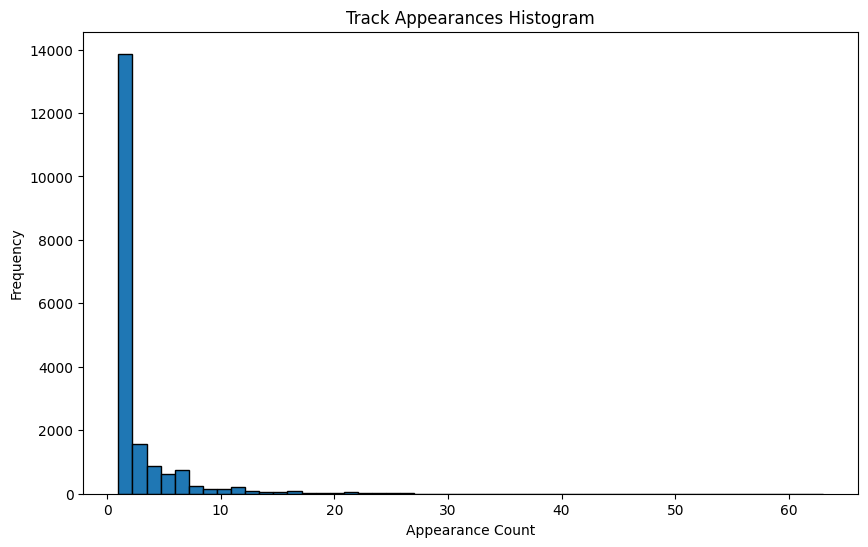

In [29]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(track_appearances['length'], bins=50, edgecolor='black')
plt.xlabel('Appearance Count')
plt.ylabel('Frequency')
plt.title('Track Appearances Histogram')
plt.show()

In [35]:
print(len(track_appearances[track_appearances['length'] > 15]))

305


Make categories
1. Selected Under 10 
2. Selected Under 20 
3. Selected Under 30 
4. Selected Under 40 
5. Selected Under 50 
6. Selected Under 60 
7. Selected Under 65

In [45]:
import numpy as np 
# Define the ranges
ranges = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 65)]

# Create DataFrames for each range
selected_dfs = []
for start, end in ranges:
    selected_tracks = track_appearances[(track_appearances['length'] >= start) & (track_appearances['length'] < end)]['track_id']
    
    # Randomly select 20 tracks (or fewer if there are less than 20 tracks)
    selected_tracks = np.random.choice(selected_tracks, min(20, len(selected_tracks)), replace=False)
    
    # Extract relevant data from the original DataFrame based on the selected track IDs
    selected_data = track_df[track_df['track_id'].isin(selected_tracks)]
    
    # Append the selected DataFrame to the list
    selected_dfs.append(selected_data)

# Access the DataFrames for each range (e.g., selected_dfs[0] for the first range)
# You can also assign them to variables if needed, like selected_df_1, selected_df_2, etc.
# Print or use these DataFrames as needed
'''
for i, selected_df in enumerate(selected_dfs):
    print(f"Selected DataFrame for Range {ranges[i]}:")
    print(selected_df.head())
    print()
'''

'\nfor i, selected_df in enumerate(selected_dfs):\n    print(f"Selected DataFrame for Range {ranges[i]}:")\n    print(selected_df.head())\n    print()\n'

Viewing spots over raw image in napari 

In [47]:
# Create a napari viewer
viewer = napari.Viewer()

# Replace 'your_file.tif' with the path to your 4D TIFF file
file_path = '/Users/apple/Desktop/Akamatsu_Lab/Lap_track/self/files/Channel3_complete.tif'

# Load the TIFF file using skimage
raw_image_3 = io.imread(file_path)

# Add the 4D stack to the viewer
layer_raw_3 = viewer.add_image(raw_image_3)

# Add Bounding Box
layer_raw_3.bounding_box.visible = True

1   HIToolbox                           0x00007ff820a90726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff820a902b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff8209ffcd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff820a90173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff81a5614b7 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff81a3b6165 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   AppKit                              0x00007ff81ae04a40 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
8   AppKit                              0x00007ff81ac57848 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721


In [49]:
for i in range(len(selected_dfs)):
    filtered_df = selected_dfs[i]
    points_layer = viewer.add_points(filtered_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                    name = f'points_range_{i}', face_color = 'yellow', symbol = 'ring')
    viewer.add_tracks(filtered_df[["track_id", "frame", "mu_z", "mu_y", "mu_x"]], name = f'track_range_{i}')

1   HIToolbox                           0x00007ff820a90726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff820a34852 SetMenuBarObscured + 226
3   HIToolbox                           0x00007ff820a344ca _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 164
4   HIToolbox                           0x00007ff820a2e996 _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 252
5   HIToolbox                           0x00007ff8209f6bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff820a2e3e6 AcquireEventFromQueue + 494
7   HIToolbox                           0x00007ff820a1d3ec ReceiveNextEventCommon + 285
8   HIToolbox                           0x00007ff820a1d2b3 _BlockUntilNextEventMatchingListInModeWithFilter + 70
9   AppKit                              0x00007ff81a224f33 _DPSNextEvent + 909
10  AppKit                              0x00007ff81a223db4 -[NSApplication(NSEvent) _ne

Plotting amplitude over time for a specific track

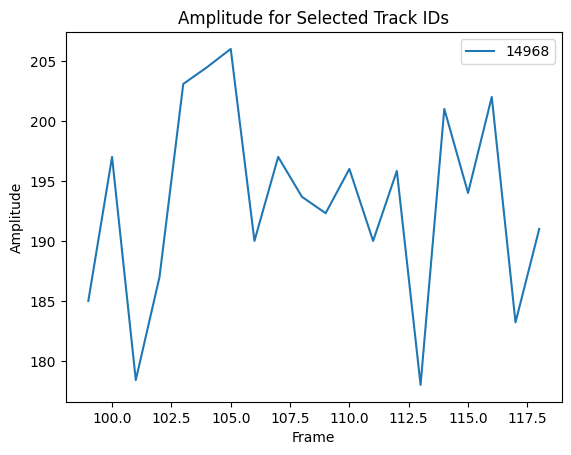

1   HIToolbox                           0x00007ff820a90726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff820a59638 _ZL17BroadcastInternaljPvh + 167
3   SkyLight                            0x00007ff81bcff74d _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 1030
4   SkyLight                            0x00007ff81c01204a _ZN21CGSDatagramReadStream26dispatchMainQueueDatagramsEv + 202
5   SkyLight                            0x00007ff81c011f71 ___ZN21CGSDatagramReadStream15mainQueueWakeupEv_block_invoke + 18
6   libdispatch.dylib                   0x00007ff816e7e7fb _dispatch_call_block_and_release + 12
7   libdispatch.dylib                   0x00007ff816e7fa44 _dispatch_client_callout + 8
8   libdispatch.dylib                   0x00007ff816e8c7b9 _dispatch_main_queue_drain + 952
9   libdispatch.dylib                   0x00007ff816e8c3f3 _dispatch_main_queue_callback_4CF + 31
10  CoreFoundation                      

In [77]:
sample_df = track_df[track_df['track_id'] == 14968]
plt.plot(sample_df['frame'], sample_df['amplitude'], label=14968)

plt.xlabel('Frame')
plt.ylabel('Amplitude')
plt.title('Amplitude for Selected Track IDs')
plt.legend()
plt.show()